# Compute downwelling irradiance for above-water radiometry purposes

## run lowtran for irradiance computation

In [2]:
import lowtran
import lowtran.plots as lp

lowtran.nm2lt7(200, 2500, 20)
c1 = {'model': 6,
      'h1': 0,
      'angle': [0, 30, 60],
      'wlshort': 300,
      'wllong': 2600,
      'wlstep': 5,

      }

In [3]:
TR = lowtran.irradiance(c1)

arguments for lowtran:  {'model': 6, 'h1': 0, 'angle': 0, 'wlshort': 300, 'wllong': 2600, 'wlstep': 5, 'itype': 3, 'iemsct': 3, 'time': None, 'h2': 0, 'im': 0, 'iseasn': 0, 'ird1': 0, 'range_km': 0, 'zmdl': 0, 'p': 0, 't': 0, 'wmol': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
arguments for lowtran:  {'model': 6, 'h1': 0, 'angle': 30, 'wlshort': 300, 'wllong': 2600, 'wlstep': 5, 'itype': 3, 'iemsct': 3, 'time': None, 'h2': 0, 'im': 0, 'iseasn': 0, 'ird1': 0, 'range_km': 0, 'zmdl': 0, 'p': 0, 't': 0, 'wmol': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
arguments for lowtran:  {'model': 6, 'h1': 0, 'angle': 60, 'wlshort': 300, 'wllong': 2600, 'wlstep': 5, 'itype': 3, 'iemsct': 3, 'time': None, 'h2': 0, 'im': 0, 'iseasn': 0, 'ird1': 0, 'range_km': 0, 'zmdl': 0, 'p': 0, 't': 0, 'wmol': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


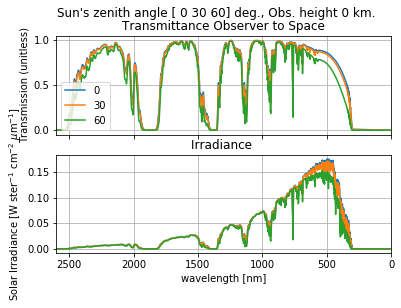

In [4]:
lp.plotirrad(TR,c1)

With basic knowlegde of `xarray`, you can easily manipulate output data.
First, look at TR content:

In [5]:
TR

<xarray.Dataset>
Dimensions:        (angle_deg: 3, time: 1, wavelength_nm: 5899)
Coordinates:
  * angle_deg      (angle_deg) int64 0 30 60
  * wavelength_nm  (wavelength_nm) float32 2600.7803 2597.4026 ... 300.03 0.0
  * time           (time) object None
Data variables:
    transmission   (time, wavelength_nm, angle_deg) float32 2.1069289e-20 ... 0.0
    radiance       (time, wavelength_nm, angle_deg) float32 4.5912e-41 ... 0.0
    irradiance     (time, wavelength_nm, angle_deg) float32 8.786022e-23 ... 0.0
    pathscatter    (time, wavelength_nm, angle_deg) float32 -99.0 -99.0 ... 0.0

Let's reproject on a new wavelength range:

In [6]:
import numpy as np
wl = np.linspace(400, 1000, 200)
TR_sub = TR.interp(wavelength_nm=wl)

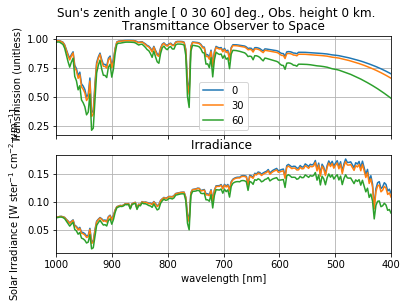

In [7]:
lp.plotirrad(TR_sub,c1)


##     run 6S downward irradiance computations

First, you have to install the version  of 6S code (radiative transfer code in Fortran). Please check [documentation](https://py6s.readthedocs.io/en/latest/installation.html) for further information.
Afterward you can load the Sixs python module:


In [1]:
import numpy as np
from Py6S import *
s = SixS()

In [2]:
sza, vza, azi = 30, 20, 40


s.geometry.solar_z = sza
s.geometry.solar_a = 0
s.geometry.view_z = vza
s.geometry.view_a = azi

In [3]:
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Maritime)

In [4]:
# wavelength in microns
s.wavelength = Wavelength(0.443)
s.run()
irr = s.outputs.diffuse_solar_irradiance + s.outputs.direct_solar_irradiance
print('Ed at 443 nm ',irr, 'W/m2/µm')

Ed at 443 nm  1278.33 W/m2/µm


In [7]:

wl = np.linspace(400, 2400, 200)
N = len(wl)

wavelengths, results = SixSHelpers.Wavelengths.run_wavelengths(s, wl / 1000,verbose=False)

F0, trans_gas, irradiance = [], [], []
for i in range(N):
    res = results[i]
    F0 = np.append(F0, res.solar_spectrum)
    trans_gas = np.append(trans_gas, res.total_gaseous_transmittance)
    irradiance = np.append(irradiance,
                           res.diffuse_solar_irradiance + res.direct_solar_irradiance)

Es_toa = F0 * np.cos(np.radians(sza))

Running for many wavelengths - this may take a long time


Easy plotting:

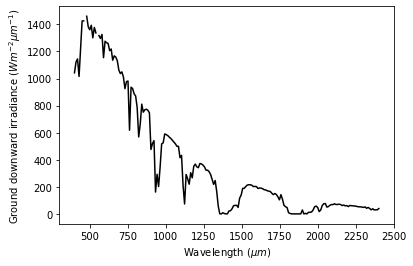

In [8]:
import matplotlib.pyplot as plt
plt.figure()
SixSHelpers.Wavelengths.plot_wavelengths(wl, irradiance, r'Ground downward irradiance $(W m^{-2} µm^{-1})$')